In [1]:
library(Seurat)
library(tidyverse)
library(foreach)
library(doParallel)
library(ggpubr)
source("/shareb/zliu/analysis/hires_gastrulation/CHARMtools/Rlibs/plotFun.R")

Registered S3 method overwritten by 'spatstat.geom':
  method     from
  print.boxx cli 

Attaching SeuratObject

── Attaching packages ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘foreach’


The followin

In [6]:
cor_test_wrapper <- function(x,y,method = "normal"){
    res <- tryCatch({
        if(method == "normal"){
            res <- cor.test(x,y,use="na.or.complete",method = "pearson")
        }
        if(method == "random"){
            y <- sample(y)
            res <- cor.test(x,y,use="na.or.complete",method = "pearson")
        }
        return(c(as.numeric(res$estimate),as.numeric(res$p.value)))
    },error = function(cond)
    {
        res <- c(NA,NA)
        return(res)
    })
    return(res)
    
}

In [2]:
mc_hires <- readRDS("hires_emb_metacell.rds")

In [3]:
DefaultAssay(mc_hires) <- "mc_sct"
FindVariableFeatures(mc_hires,nfeatures = 3000) -> mc_hires
gene_consider <- VariableFeatures(mc_hires)

In [4]:
distance_on_di_mc <- mc_hires[["mc_di"]]@data %>% as.matrix() %>% t()
sctRNAmat <- mc_hires[["mc_sct"]]@data %>% as.matrix() %>% t() 
sctRNAmat_temp <- sctRNAmat[,gene_consider]

In [5]:
genes <- read_tsv("/share/Data/public/ref_genome/mouse_ref/M23/raw_data/gene.bed",col_names = FALSE)
names(genes) <- c("chrom","start","end","id","name","strand")
genes <- genes %>% mutate(length = end - start) %>% arrange(desc(length)) %>% group_by(name) %>% slice(1) %>% ungroup() %>% valr::bed_sort() %>% select(-length)
head(genes)

Rows: 55335 Columns: 6
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (4): X1, X4, X5, X6
dbl (2): X2, X3

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


chrom,start,end,id,name,strand
<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>
chr1,3073252,3074322,ENSMUSG00000102693.1,4933401J01Rik,+
chr1,3102015,3102125,ENSMUSG00000064842.1,Gm26206,+
chr1,3205900,3671498,ENSMUSG00000051951.5,Xkr4,-
chr1,3252756,3253236,ENSMUSG00000102851.1,Gm18956,+
chr1,3365730,3368549,ENSMUSG00000103377.1,Gm37180,-
chr1,3375555,3377788,ENSMUSG00000104017.1,Gm37363,-


In [7]:
cor_test_wrapper(distance_on_di_mc[,"chr18-72340000-73160000"],sctRNAmat_temp[,"Dcc"]) # positive
cor_test_wrapper(distance_on_di_mc[,"chr18-72340000-73160000"],sctRNAmat_temp[,"Dcc"],method = "random") # Random
#cor_test_wrapper(distance_on_di_mc[,"chr19-58180000-58640000"],sctRNAmat_temp[,"Dcc"]) # negative
dim(sctRNAmat_temp)
dim(distance_on_di_mc)

[1] -7.924805e-01  2.535851e-35

[1] 0.1056123 0.1866076

[1]  158 3000

[1]    158 535780

In [8]:
#flank_size = 2000000
flank_size = 500000
alltypes_consider <- read_tsv("alldis.filtered.tsv.gz")
di_entrys <- alltypes_consider %>% mutate(chrom=chrom1,start=start1 - flank_size,end=end2+flank_size) %>% select(chrom,start,end,pos) %>% unique()
#genes_templist <- intersect(valr::bed_intersect(genes,di_entry) %>% pull(name.x),gene_consider)
genes_templist <- valr::bed_intersect(genes,di_entrys) %>% filter(name.x %in% gene_consider)
genes_di_pair <- genes_templist %>% select(name.x,pos.y) 
names(genes_di_pair) <- c("name","pos")

Rows: 694384 Columns: 13
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (4): chrom1, chrom2, pos, celltype
dbl (9): start1, end1, start2, end2, pv, FDR, diff, mat1_mean_all, mat2_mean...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [9]:
genes_di_pair %>% mutate(pos = str_replace_all(pos,"_","-")) -> genes_di_pair

In [10]:
dim(genes_di_pair)

[1] 1174515       2

In [11]:
registerDoParallel(40)

start = Sys.time()
chunck_size = 1000
num = floor(dim(genes_di_pair)[1]/chunck_size)
di_gene_cor <- foreach(i = seq(num), .combine = "rbind", .errorhandling = "stop") %dopar% {
    temp <- genes_di_pair[((i-1)*chunck_size+1):(i*chunck_size),] %>% rowwise() %>% mutate(cor = list(cor_test_wrapper(distance_on_di_mc[,pos],sctRNAmat_temp[,name]))) 
    temp <- cbind(temp[c(1,2)], t(data.frame(temp$cor))) %>% as_tibble()
    names(temp) <- c("name","pos","cor","pv")
    return(temp)
}

end = Sys.time()
print(end -start)

Time difference of 2.919335 mins


In [12]:
i=num + 1
temp <- genes_di_pair[((i-1)*chunck_size+1):(i*chunck_size),]  %>% na.omit()%>% rowwise() %>% mutate(cor = list(cor_test_wrapper(distance_on_di_mc[,pos],sctRNAmat_temp[,name]))) 
temp <- cbind(temp[c(1,2)], t(data.frame(temp$cor))) %>% as_tibble()
names(temp) <- c("name","pos","cor","pv")

In [13]:
di_gene_cor <- rbind(di_gene_cor,temp)

Warning message:
“Using `bins = 30` by default. Pick better value with the argument `bins`.”


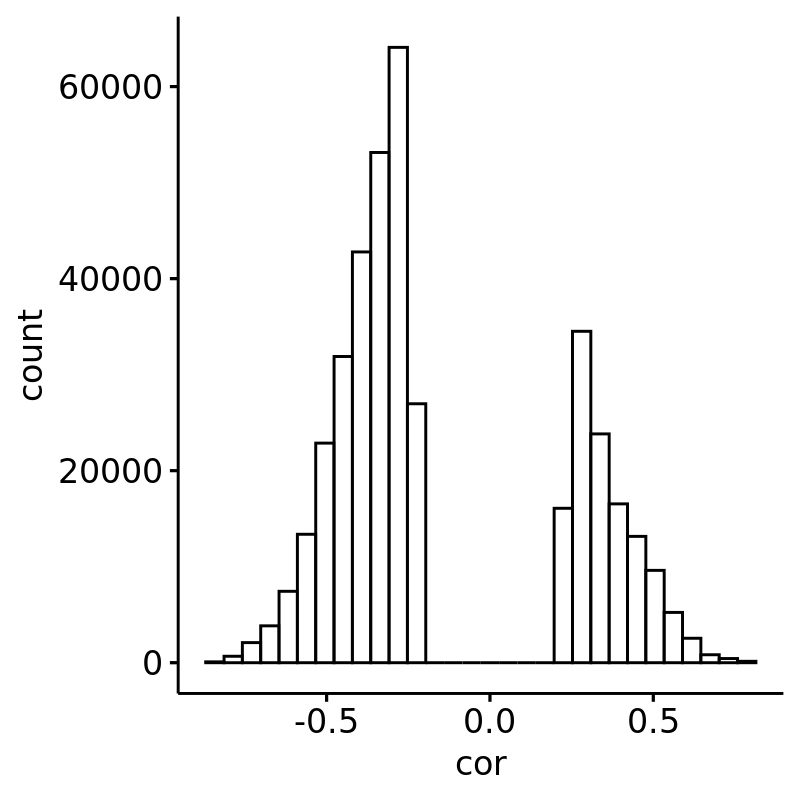

In [14]:
options(repr.plot.height = 4, repr.plot.width = 4,repr.plot.res = 200)
di_gene_cor %>% mutate(fdr = p.adjust(pv,method = "BH")) %>% filter(fdr < 0.01) %>% gghistogram(x="cor")

Warning message:
“Using `bins = 30` by default. Pick better value with the argument `bins`.”
Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”


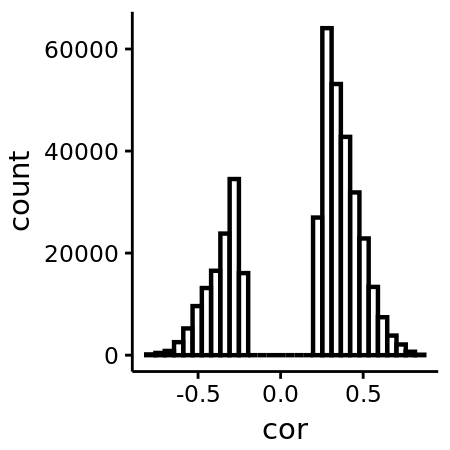

In [25]:
options(repr.plot.height = 1.5, repr.plot.width = 1.5,repr.plot.res = 300)
p <- di_gene_cor %>% mutate(fdr = p.adjust(pv,method = "BH"),cor = -cor) %>% filter(fdr < 0.01) %>% gghistogram(x="cor") + theme_Publication()
p
p %>% ggsave(filename = "plots/DI_cor.pdf",width = 1.5,height=1.5,dpi = 300)

In [15]:
di_gene_cor %>% write_tsv("hires_allcor.500k.tsv.gz")

In [27]:
paste0("chr",seq(1:19))->chroms 
alldis <- read_tsv("alldis.tsv.gz")
paste0("di_all/Random41.",chroms,".tsv") |> map(read_tsv) %>% bind_rows() %>% suppressMessages() -> random_di
diposs <- alldis %>% pull(pos) %>% unique()
random_di <- random_di %>% filter(!pos %in% diposs)
random_loci <- random_di %>% pull(pos) %>% unique()

chrom_mat_list_all <- list()
for (c in seq(1:19)){
    print(paste0("Chromosome ",c," processing!"))
    flush.console() 
    chrom_temp <- readRDS(paste0("di_mat/chr",as.character(c),".mat.rds.gz"))
    names_temp <- intersect(names(chrom_temp),random_loci)
    chrom_mat_list_all[[c]] <- chrom_temp[,names_temp]
    print(paste0("Chromosome ",c," done!"))
    flush.console()
}
mat_all <- chrom_mat_list_all[[1]]
for (i in seq(1,19)){
    mat_all <- cbind(mat_all,chrom_mat_list_all[[i]])
}

mat_all <- mat_all[,intersect(names(mat_all),random_loci)]

Rows: 6298960 Columns: 13
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (4): chrom1, chrom2, pos, celltype
dbl (9): start1, end1, start2, end2, pv, FDR, diff, mat1_mean_all, mat2_mean...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "Chromosome 1 processing!"
[1] "Chromosome 1 done!"
[1] "Chromosome 2 processing!"
[1] "Chromosome 2 done!"
[1] "Chromosome 3 processing!"
[1] "Chromosome 3 done!"
[1] "Chromosome 4 processing!"
[1] "Chromosome 4 done!"
[1] "Chromosome 5 processing!"
[1] "Chromosome 5 done!"
[1] "Chromosome 6 processing!"
[1] "Chromosome 6 done!"
[1] "Chromosome 7 processing!"
[1] "Chromosome 7 done!"
[1] "Chromosome 8 processing!"
[1] "Chromosome 8 done!"
[1] "Chromosome 9 processing!"
[1] "Chromosome 9 done!"
[1] "Chromosome 10 processing!"
[1] "Chromosome 10 done!"
[1] "Chromosome 11 processing!"
[1] "Chromosome 11 done!"
[1] "Chromosome 12 processing!"
[1] "Chromosome 12 done!"
[1] "Chromosome 13 processing!"
[1] "Chromosome 13 done!"
[1] "Chromosome 14 processing!"
[1] "Chromosome 14 done!"
[1] "Chromosome 15 processing!"
[1] "Chromosome 15 done!"
[1] "Chromosome 16 processing!"
[1] "Chromosome 16 done!"
[1] "Chromosome 17 processing!"
[1] "Chromosome 17 done!"
[1] "Chromosome 18 processing!"


In [28]:
set.seed(42) 
distance_on_di <- mat_all
distance_on_di <- distance_on_di[c(TRUE,FALSE),] + distance_on_di[c(FALSE,TRUE),]
distance_on_di <- as.data.frame(distance_on_di)
rownames(distance_on_di) <- rownames(distance_on_di) %>% str_remove("mat")

In [29]:
metacell_assign <- read_tsv("metacell_assign.txt")

Rows: 3594 Columns: 4
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (3): cellname, mc_id, celltype
dbl (1): cellnum

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [30]:
chunk_size = 10000
split_num = floor(dim(distance_on_di)[2] / chunk_size)

set.seed(42)
registerDoParallel(30)
distance_on_di_mc <- foreach(i = seq(split_num), .combine = "cbind",.errorhandling = "stop") %dopar% 
{   
    distance_on_di[,((i-1)*chunk_size + 1):(i * chunk_size)]%>% rownames_to_column("cellname") %>% inner_join(metacell_assign) %>% 
    select(-cellname,-celltype) %>% group_by(mc_id) %>% summarise_all(mean,na.rm=T) %>% column_to_rownames("mc_id") 
}
distance_on_di_mc <- cbind(distance_on_di_mc,distance_on_di[,(dim(distance_on_di_mc)[2]+1):dim(distance_on_di)[2]]%>% rownames_to_column("cellname") %>% inner_join(metacell_assign) %>% 
    select(-cellname,-celltype) %>% group_by(mc_id) %>% summarise_all(mean,na.rm=T) %>% column_to_rownames("mc_id"))

Joining, by = "cellname"


In [31]:
flank_size = 500000
di_entrys <- random_di %>% filter(pos %in% random_loci) %>% mutate(chrom=chrom1,start=start1 - flank_size,end=end2+flank_size) %>% select(chrom,start,end,pos) %>% unique()
genes_templist <- valr::bed_intersect(genes,di_entrys) %>% filter(name.x %in% gene_consider)
genes_di_pair <- genes_templist %>% select(name.x,pos.y) 
names(genes_di_pair) <- c("name","pos")

In [33]:
registerDoParallel(5)

start = Sys.time()
chunck_size = 1000
num = floor(dim(genes_di_pair)[1]/chunck_size)
di_gene_cor <- foreach(i = seq(num), .combine = "rbind", .errorhandling = "stop") %dopar% {
    temp <- genes_di_pair[((i-1)*chunck_size+1):(i*chunck_size),] %>% rowwise() %>% mutate(cor = list(cor_test_wrapper(distance_on_di_mc[,pos],sctRNAmat_temp[,name]))) 
    temp <- cbind(temp[c(1,2)], t(data.frame(temp$cor))) %>% as_tibble()
    names(temp) <- c("name","pos","cor","pv")
    return(temp)
}

end = Sys.time()
print(end -start)

Time difference of 55.83322 mins


In [34]:
di_gene_cor %>% write_tsv("hires_allcor.random.500k.tsv.gz")

In [41]:
random_cor <- read_tsv("hires_allcor.random.500k.tsv.gz")%>% sample_n(949863) %>% mutate(type = "Random",fdr = p.adjust(pv,method = "BH"))
di_cor <- read_tsv("hires_allcor.500k.tsv.gz") %>% mutate(type = "Gadi",fdr = p.adjust(pv,method = "BH"))

Rows: 1101000 Columns: 4
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): name, pos
dbl (2): cor, pv

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 949863 Columns: 4
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): name, pos
dbl (2): cor, pv

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [42]:
random_cor %>% filter(fdr < 0.01) %>% group_by(name) %>% summarise(count = n()) %>% summary()

     name               count        
 Length:780         Min.   :  1.000  
 Class :character   1st Qu.:  1.000  
 Mode  :character   Median :  3.000  
                    Mean   :  8.521  
                    3rd Qu.:  8.000  
                    Max.   :126.000  

In [43]:
di_gene_cor <- rbind(di_cor, random_cor)

# Random control by shuffle gene

In [16]:
registerDoParallel(60)

start = Sys.time()
chunck_size = 1000
num = floor(dim(genes_di_pair)[1]/chunck_size)
di_gene_cor_random <- foreach(i = seq(num), .combine = "rbind", .errorhandling = "stop") %dopar% {
    temp <- genes_di_pair[((i-1)*chunck_size+1):(i*chunck_size),] %>% rowwise() %>% mutate(cor = list(cor_test_wrapper(distance_on_di_mc[,pos],sctRNAmat_temp[,name],method="random"))) 
    temp <- cbind(temp[c(1,2)], t(data.frame(temp$cor))) %>% as_tibble()
    names(temp) <- c("name","pos","cor","pv")
    return(temp)
}

end = Sys.time()
print(end -start)

Time difference of 2.858414 mins


In [17]:
i=num + 1
temp <- genes_di_pair[((i-1)*chunck_size+1):(i*chunck_size),]  %>% na.omit()%>% rowwise() %>% mutate(cor = list(cor_test_wrapper(distance_on_di_mc[,pos],sctRNAmat_temp[,name],method="random"))) 
temp <- cbind(temp[c(1,2)], t(data.frame(temp$cor))) %>% as_tibble()
names(temp) <- c("name","pos","cor","pv")
di_gene_cor_random <- rbind(di_gene_cor_random,temp)

In [34]:
di_gene_cor_random %>% write_tsv("hires_allcor.random.500k.tsv.gz")

In [28]:
compare <- rbind(di_gene_cor %>% mutate(type = "GADI"),di_gene_cor_random %>% mutate(type="Shuffle")) %>% mutate(cor = - cor)

Warning message:
“Using `bins = 30` by default. Pick better value with the argument `bins`.”
Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”


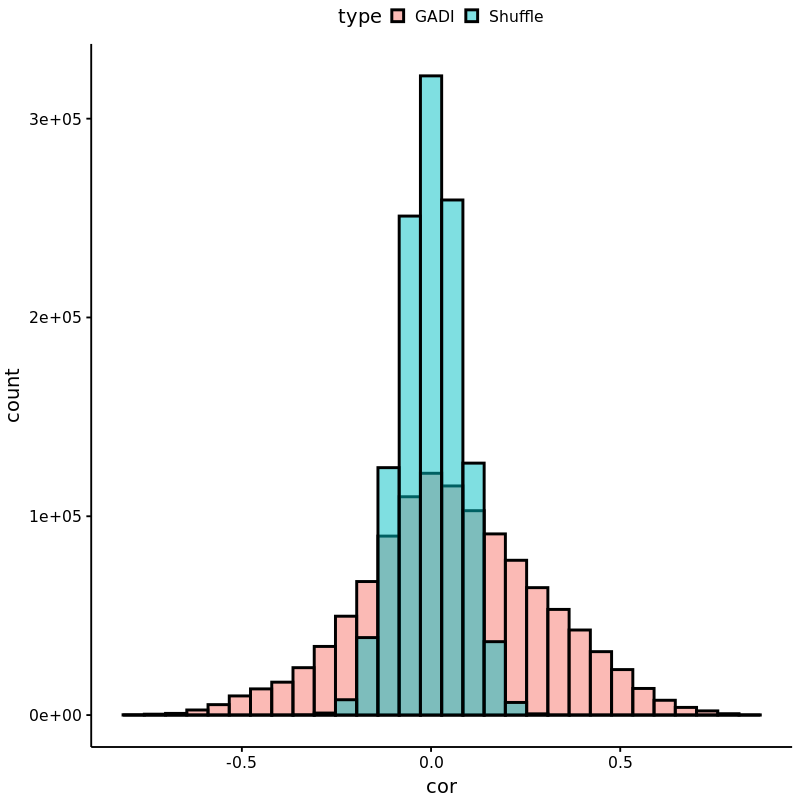

In [29]:
options(repr.plot.height = 4, repr.plot.width = 4,repr.plot.res = 200)
p <- compare %>% gghistogram(x="cor",fill = "type") + theme_Publication()
p
p %>% ggsave(filename = "gadi_control_histogram.pdf",width = 2, height = 2, dpi=300)

In [45]:
compare %>% group_by(type) %>% mutate(fdr = p.adjust(pv,method="BH")) %>% filter(fdr < 0.01) -> compare_significant

In [47]:
p <- compare_significant %>% gghistogram(x="cor",fill = "type") + theme_Publication()
p %>% ggsave(filename = "plots/gadi_significant_histogram.pdf",width = 1.5, height = 1.5, dpi=300)

Warning message:
“Using `bins = 30` by default. Pick better value with the argument `bins`.”
Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”
